# Importing modules

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

# Fearture engineering

### Columns to drop

In [37]:
columns_to_drop=[
    'transaction_id',
    'customer_unique_id',
    'anomaly_types',
    'created_at',
    'updated_at',
    'bill_date',
    'business_date',
    'rule_id',
    'rule_type',
    'item_code',
    'sku_category_code',
    'category_code',
    'store_id',
    'activity_id',
    'funding_partner_id'
]

# Preprocessing Function

In [38]:
def preprocessing(df):
    df = df.drop(columns=columns_to_drop)
    
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    
    df['hours'] = df['transaction_date'].dt.hour
    df['day_of_week'] = df['transaction_date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df = df.drop(columns=['transaction_date'])
    
    return df

# Training Function

In [39]:
def training(df):
    
    df = preprocessing(df)
    
    X = df.drop(columns=['is_anomaly'])
    y = df['is_anomaly']
    
    cat_cols = X.select_dtypes(include=['str', 'object']).columns
    
    neg = (y == 0).sum()
    pos = (y == 1).sum()
    
    scale_weight = neg/pos
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)
    
    model = CatBoostClassifier(class_weights=[1, scale_weight], verbose=0)
    
    model.fit(X_train, y_train, cat_features=cat_cols.tolist())
    
    y_prob = model.predict_proba(X_test)[:,1]
    threshold = 0.3
    y_pred = (y_prob > threshold).astype(int)

    
    # decile_bins = np.percentile(y_prob, [10,20,30,40,50,60,70,80,90])
    
    # def assign_decile(prob, bins):
    #     for i, cutoff in enumerate(bins):
    #         if prob <= cutoff:
    #             return f"D{i+1}"
    #     return "D10"

    # result_df = pd.DataFrame({
    #     "actual": y_test.values,
    #     "probability": y_prob,
    #     "predicted": y_pred
    # })

    # result_df["decile"] = result_df["probability"].apply(
    #     lambda x: assign_decile(x, decile_bins)
    # )
    
    # def assign_severity(decile):
    #     if decile == "D10":
    #         return "Very High Risk"
    #     elif decile in ["D8", "D9"]:
    #         return "High Risk"
    #     elif decile in ["D5", "D6", "D7"]:
    #         return "Medium Risk"
    #     else:
    #         return "Low Risk"

    # result_df["severity"] = result_df["decile"].apply(assign_severity)
    
    # ACTION_ORDER = ["Very High Risk", "High Risk", "Medium Risk", "Low Risk"]

    # print("\nNon-Anomalies Distribution")
    # good_table = (
    #     result_df[result_df["actual"] == 0]["severity"]
    #     .value_counts()
    #     .reindex(ACTION_ORDER, fill_value=0)
    #     .to_frame("Count")
    # )
    # good_table["%"] = (
    #     good_table["Count"] / good_table["Count"].sum() * 100
    # ).round(2)
    # print(good_table)

    # print("\nAnomalies Distribution")
    # bad_table = (
    #     result_df[result_df["actual"] == 1]["severity"]
    #     .value_counts()
    #     .reindex(ACTION_ORDER, fill_value=0)
    #     .to_frame("Count")
    # )
    # bad_table["%"] = (
    #     bad_table["Count"] / bad_table["Count"].sum() * 100
    # ).round(2)
    # print(bad_table)

    # # -----------------------------
    # # Decile Performance Table
    # # -----------------------------
    # decile_summary = (
    #     result_df.groupby("decile")
    #     .agg(
    #         total=("actual","count"),
    #         bad=("actual","sum")
    #     )
    # )

    # decile_summary["bad_rate"] = (
    #     decile_summary["bad"] / decile_summary["total"]
    # ).round(4)

    # print("\nDecile Performance Table")
    # print(decile_summary.sort_index())

    return model, y_test, y_pred, y_prob

# Metrics

In [46]:
def metrics(y_test, y_pred, y_prob):
    print("\nModel Metrics")
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("PR AUC:", average_precision_score(y_test, y_prob))
    print("F1:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Decile

In [41]:
def decile_cal(y_test, y_prob, y_pred):
    decile_bins = np.percentile(y_prob, [10,20,30,40,50,60,70,80,90])
    
    def assign_decile(prob, bins):
        for i, cutoff in enumerate(bins):
            if prob <= cutoff:
                return f"D{i+1}"
        return "D10"

    result_df = pd.DataFrame({
        "actual": y_test.values,
        "probability": y_prob,
        "predicted": y_pred
    })

    result_df["decile"] = result_df["probability"].apply(
        lambda x: assign_decile(x, decile_bins)
    )
    
    def assign_severity(decile):
        if decile == "D10":
            return "Very High Risk"
        elif decile in ["D8", "D9"]:
            return "High Risk"
        elif decile in ["D5", "D6", "D7"]:
            return "Medium Risk"
        else:
            return "Low Risk"

    result_df["severity"] = result_df["decile"].apply(assign_severity)
    
    ACTION_ORDER = ["Very High Risk", "High Risk", "Medium Risk", "Low Risk"]

    print("\nNon-Anomalies Distribution")
    good_table = (
        result_df[result_df["actual"] == 0]["severity"]
        .value_counts()
        .reindex(ACTION_ORDER, fill_value=0)
        .to_frame("Count")
    )
    good_table["%"] = (
        good_table["Count"] / good_table["Count"].sum() * 100
    ).round(2)
    print(good_table)

    print("\nAnomalies Distribution")
    bad_table = (
        result_df[result_df["actual"] == 1]["severity"]
        .value_counts()
        .reindex(ACTION_ORDER, fill_value=0)
        .to_frame("Count")
    )
    bad_table["%"] = (
        bad_table["Count"] / bad_table["Count"].sum() * 100
    ).round(2)
    print(bad_table)

    # -----------------------------
    # Decile Performance Table
    # -----------------------------
    decile_summary = (
        result_df.groupby("decile")
        .agg(
            total=("actual","count"),
            bad=("actual","sum")
        )
    )

    decile_summary["bad_rate"] = (
        decile_summary["bad"] / decile_summary["total"]
    ).round(4)

    print("\nDecile Performance Table")
    print(decile_summary.sort_index())
    
    return result_df

# Load Data

In [42]:
print("Loading datasets...")

accu_df = pd.read_csv("Datasets/synthetic_accural_data.csv")
redm_df = pd.read_csv("Datasets/synthetic_redeem_data.csv")

print("Datasets loaded.")

Loading datasets...
Datasets loaded.


# Train Accrual Model

### train accural DF

In [43]:
accu_model, accu_y_test, accu_y_pred, accu_y_prob = training(accu_df)

### Printing metrics

In [47]:
metrics(accu_y_test, accu_y_pred, accu_y_prob)


Model Metrics
ROC AUC: 0.9311780349245082
PR AUC: 0.8326202378010937
F1: 0.6508313539192399
Precision: 0.5209125475285171
Recall: 0.8670886075949367
Confusion Matrix:
 [[1076  252]
 [  42  274]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      1328
           1       0.52      0.87      0.65       316

    accuracy                           0.82      1644
   macro avg       0.74      0.84      0.77      1644
weighted avg       0.88      0.82      0.84      1644



### Printing decile

In [ ]:
accu_result_df = decile_cal(accu_y_test, accu_y_prob, accu_y_pred)


Non-Anomalies Distribution
                Count      %
severity                    
Very High Risk      6   0.45
High Risk         218  16.42
Medium Risk       453  34.11
Low Risk          651  49.02

Anomalies Distribution
                Count      %
severity                    
Very High Risk    159  50.32
High Risk         110  34.81
Medium Risk        40  12.66
Low Risk            7   2.22

Decile Performance Table
        total  bad  bad_rate
decile                      
D1        165    1    0.0061
D10       165  159    0.9636
D2        164    1    0.0061
D3        164    3    0.0183
D4        165    2    0.0121
D5        164    3    0.0183
D6        164   12    0.0732
D7        165   25    0.1515
D8        164   37    0.2256
D9        164   73    0.4451


In [ ]:
accu_result_df

,actual,probability,predicted,decile,severity
0,0,0.914159,1,D9,High Risk
1,1,0.558555,1,D9,High Risk
2,1,0.326256,1,D7,Medium Risk
3,0,0.214180,0,D7,Medium Risk
4,0,0.242223,0,D7,Medium Risk
...,...,...,...,...,...
1639,1,0.999498,1,D10,Very High Risk
1640,1,0.581662,1,D9,High Risk
1641,0,0.005640,0,D1,Low Risk
1642,0,0.029544,0,D3,Low Risk


# Train Redemption Model

### train redemption DF

In [49]:
redm_model, redm_y_test, redm_y_pred, redm_y_prob = training(redm_df)

### Printing Metrics

In [50]:
metrics(redm_y_test, redm_y_pred, redm_y_prob)


Model Metrics
ROC AUC: 0.8132884777123633
PR AUC: 0.673933933492401
F1: 0.6208530805687204
Precision: 0.4729241877256318
Recall: 0.903448275862069
Confusion Matrix:
 [[182 146]
 [ 14 131]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.55      0.69       328
           1       0.47      0.90      0.62       145

    accuracy                           0.66       473
   macro avg       0.70      0.73      0.66       473
weighted avg       0.79      0.66      0.67       473



### Printing Decile

In [51]:
redm_result_df = decile_cal(redm_y_test, redm_y_prob, redm_y_pred)


Non-Anomalies Distribution
                Count      %
severity                    
Very High Risk     10   3.05
High Risk          48  14.63
Medium Risk        92  28.05
Low Risk          178  54.27

Anomalies Distribution
                Count      %
severity                    
Very High Risk     38  26.21
High Risk          46  31.72
Medium Risk        50  34.48
Low Risk           11   7.59

Decile Performance Table
        total  bad  bad_rate
decile                      
D1         48    1    0.0208
D10        48   38    0.7917
D2         47    2    0.0426
D3         47    2    0.0426
D4         47    6    0.1277
D5         48   14    0.2917
D6         47   19    0.4043
D7         47   17    0.3617
D8         47   23    0.4894
D9         47   23    0.4894


In [56]:
redm_result_df

,actual,probability,predicted,decile,severity
0,1,0.860124,1,D10,Very High Risk
1,0,0.415781,1,D6,Medium Risk
2,0,0.831409,1,D10,Very High Risk
3,0,0.141843,0,D3,Low Risk
4,0,0.133444,0,D2,Low Risk
...,...,...,...,...,...
468,0,0.075949,0,D1,Low Risk
469,1,0.945200,1,D10,Very High Risk
470,0,0.467377,1,D7,Medium Risk
471,0,0.285566,0,D4,Low Risk


# Metrics

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_decile_distribution(result_df, title="Risk Distribution by Decile"):

    # Ensure proper decile order
    decile_order = [f"D{i}" for i in range(1, 11)]

    # Build summary table
    bin_summary = (
        result_df.groupby(["decile", "actual"])
        .size()
        .unstack(fill_value=0)
        .reindex(decile_order)
    )

    bin_summary["total"] = bin_summary[0] + bin_summary[1]
    bin_summary["bad_rate"] = (
        bin_summary[1] / bin_summary["total"]
    ).round(4)

    bin_summary = bin_summary.reset_index()

    # -----------------------------
    # Plot
    # -----------------------------
    plt.figure(figsize=(10,6))

    bars_good = plt.bar(
        range(len(bin_summary)),
        bin_summary[0],
        label="Good",
        color="skyblue"
    )

    bars_bad = plt.bar(
        range(len(bin_summary)),
        bin_summary[1],
        bottom=bin_summary[0],
        label="Bad",
        color="orange"
    )

    # Add labels
    for i in range(len(bin_summary)):
        if bin_summary[0][i] > 0:
            plt.text(
                i,
                bin_summary[0][i] / 2,
                f"{bin_summary[0][i]}",
                ha="center",
                va="center",
                fontsize=9
            )

        if bin_summary[1][i] > 0:
            plt.text(
                i,
                bin_summary[0][i] + bin_summary[1][i] / 2,
                f"{bin_summary[1][i]}",
                ha="center",
                va="center",
                fontsize=9
            )

    plt.xticks(range(len(bin_summary)), decile_order)
    plt.xlabel("Risk Score Deciles (Low → High Risk)")
    plt.ylabel("Number of Customers")
    plt.title(title)
    plt.legend()
    plt.grid(axis="y", alpha=0.3)

    plt.show()

    return bin_summary

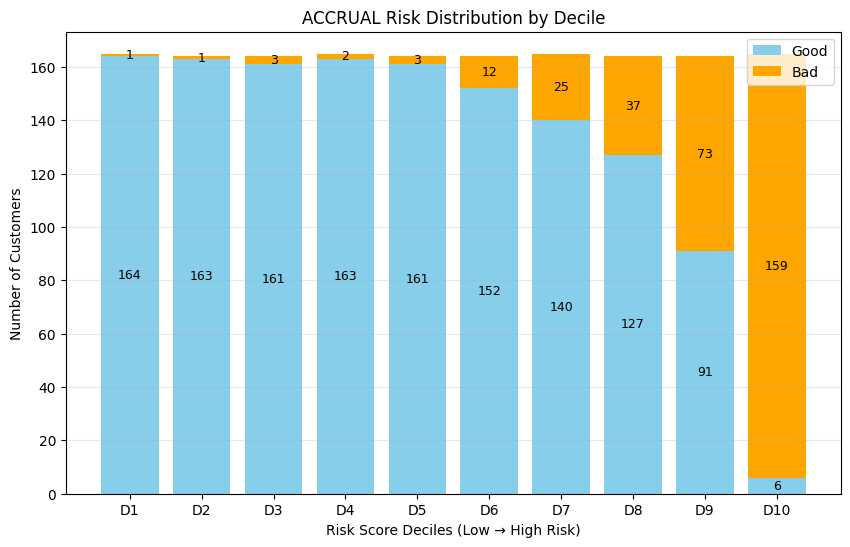

In [53]:
accu_summary = plot_decile_distribution(accu_result_df, title="ACCRUAL Risk Distribution by Decile")

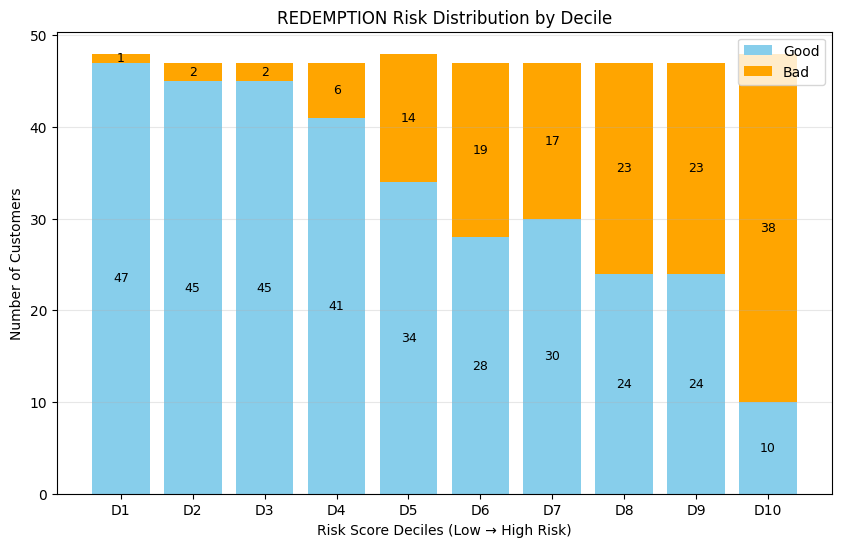

In [54]:
redm_summary = plot_decile_distribution(redm_result_df, title="REDEMPTION Risk Distribution by Decile")